# Classification de données non linéaires avec une couche cachée

Bonjour et bienvenue à ce workshop dans lequel nous allons construire notre premier réseau de neurones profond (deep learning), contenant une couche cachée. Vous remarquerez une grosse différence entre ce modèle et celui que vous avez implémenté avec la régression logistique.


**Ce que vous allez apprendre:**
- Implémenter un réseau de neurones avec une couche cachée pour une classification à 2 classes
- Utiliser les neurones avec une fonction d'activation non linéaire, comme la tanh
- Calculer la loss cross-entropy
- Implémenter les forward et backward propagations

## 1 - Packages ##

Commençons par importer les packages dont nous aurons besoin:
- [numpy](www.numpy.org) est le package fondamental pour le calcul scientifique en Python.
- [sklearn](http://scikit-learn.org/stable/) dispose de nombreuses fonctions pour la construction et l'analyse des données. 
- [matplotlib](http://matplotlib.org) est une librairie pour afficher des graphes, tableaux, etc. en Python.
- tests fournit quelques exemples tests pour vérifier vos fonctions
- utils fournit de nombreuses fonctions utiles dont nous avons besoin pour ce notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tests import *
import sklearn
import sklearn.datasets
import sklearn.linear_model
from utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets

%matplotlib inline

np.random.seed(1) # seed pour comparer avec les valeurs attendues, ne pas modifier !!

## 2 - Dataset ##

Tout d'abord, récupérons le jeu de données. Le code suivant va initialiser un jeu de données "fleur" à 2 classes dans les  variables `X` et `Y`.

In [2]:
X, Y = load_planar_dataset()

Visualisez le jeu de données avec matplotlib. Les données ressemblent à une "fleur" avec des points rouges (label y = 0) et bleus (y = 1). Votre but est de construire un modèle qui classeront correctement ces données.

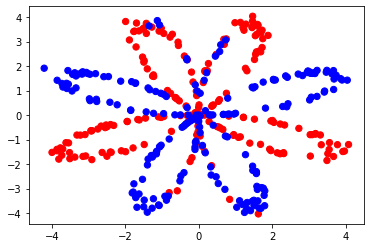

In [3]:
c = []
for i in range(Y.shape[1]):
    if i < Y.shape[1] / 2: c.append('red')
    else: c.append('blue')
plt.scatter(X[0, :], X[1, :], c=c, s=40, cmap=plt.cm.Spectral);

Vous avez:
    - un numpy-array (matrix) X qui contient vos features (x1, x2)
    - un numpy-array (vecteur) Y qui contient vos labels (rouge:0, bleu:1).

Analysons davantage nos données.

**Exercice**: Combien d'exemples de train avez vous ? De plus, quels sont les shapes des variables `X` et `Y`? 

**Indice**: Comment récupérez vous le shape d'un numpy array ? [(help)](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.shape.html)

In [4]:
### Début du code ### (≈ 2 lignes de code)
shape_X = X.shape
shape_Y = Y.shape
### Fin du code ###

print ('Le shape de X est: ' + str(shape_X))
print ('Le shape de Y est: ' + str(shape_Y))

Le shape de X est: (2, 400)
Le shape de Y est: (1, 400)


**Résultat attendu**:
       
<table style="width:20%">
  
  <tr>
    <td>shape de X</td>
    <td> (2, 400) </td> 
  </tr>
  
  <tr>
    <td>shape de Y</td>
    <td>(1, 400) </td> 
  </tr>

  </tr>
  
</table>

## 3 - Simple régression logistique

Avant de construire un réseau de neurones complet, visualisons les performances de la régression logistique à ce problème. Vous pouvez utilisez les fonctions de sklearn pour le faire. Exécutez la cellule suivant pour entraîner une régression logistique sur notre jeu de données. 

In [5]:
# Entrainement du classifier régression logistique
clf = sklearn.linear_model.LogisticRegressionCV(cv=5);
clf.fit(X.T, Y.T.ravel());

Vous pouvez maintenant plotter le decision boundary (limite de décision) de ce modèle. Exécutez le code suivant. 

**Attention:** Suite à des problèmes de versions matplotlib, il se peut que vous ne voyez pas les points initiaux. L'important est de voir comment la régression logistique a apporté sa solution au problème. Appelez un assistant si vous ne comprenez pas.

Accuracy de la régression logistique: 47 % de points labellisés corrects


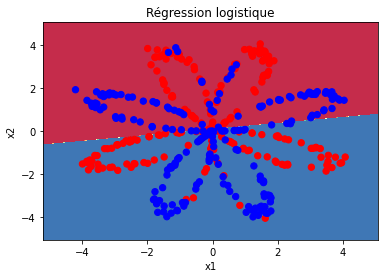

In [6]:
# Plot de la decision boundary pour la régression logistique
try:
    plot_decision_boundary(lambda x: clf.predict(x), X, Y)
except:
    print("Suite à un problème de version matplotlib, vous ne voyez pas les points initiaux. Reprenez le graphique précédent et imaginez les points comme étant plot.")
    pass
plt.title("Régression logistique")

# Print l'accuracy
LR_predictions = clf.predict(X.T)
print ('Accuracy de la régression logistique: %d ' % float((np.dot(Y,LR_predictions) + np.dot(1-Y,1-LR_predictions))/float(Y.size)*100) +
       '% ' + "de points labellisés corrects")

**Résultat attendu**:

<table style="width:20%">
  <tr>
    <td>Accuracy</td>
    <td> 47% </td> 
  </tr>
  
</table>


**Interpretation**: Ce jeu de données n'est pas linéairement séparable, donc la logistique régression ne fonctionne pas ici. Heureusement, un réseau de neurones profond pourra résoudre notre problème. C'est parti ! 

## 4 - Réseau de neurones profond

La régression logistique ne fonctionne pas sur notre jeu de données. Vous allez maintenant entraîner un réseau de neurones profond avec une couche cachée.

**Voici notre modèle**:
<img src="images/classification_kiank.png" style="width:600px;height:300px;">

**Mathématiquement**:

Pour un exemple $x^{(i)}$:
$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1]}\tag{1}$$ 
$$a^{[1] (i)} = \tanh(z^{[1] (i)})\tag{2}$$
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2]}\tag{3}$$
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{4}$$
$$y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{si } a^{[2](i)} > 0.5 \\ 0 & \mbox{sinon } \end{cases}\tag{5}$$

A partir des prédictions calculées, vous pourrez calculer le coût grâce à la formule suivante:
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{6}$$

**Rappel**: La méthodologie générale pour construire un réseau de neurones est la suivante:
    1. Définir la structure du réseau de neurones ( nombre de features en entrée,  nombre de couches cachées, etc). 
    2. Initialiser les paramètres du modèle
    3. Boucle:
        - Implémenter la forward propagation
        - Calcul du coût
        - Implémenter la backward propagation pour avoir les gradients
        - Update des paramètres 

Après avoir créé vos fonctions, vous allez les merger en une unique fonction qu'on nommera `nn_model()`. 
Quand ce modèle sera entraîné, vous pourrez réaliser des prédictions sur des nouvelles données.

### 4.1 - Définir la structure du réseau de neurones ####

**Exercice**: Définissez 3 variables:
    - n_x: size de la couche d'entrée
    - n_h: size de la couche cachée (définissez la à 4) 
    - n_y: size de la couche de sortie

**Indice**: Utilisez les shapes de X et Y pour trouver n_x et n_y. Hardcodez directement la couche cachée.

In [7]:
def layer_sizes(X, Y):
    """
    Arguments:
    X -- jeu de données en entrée de shape (size en entrée, nombre d'exemples)
    Y -- labels de shape (size en sortie, nombre d'exemples)
    """
    ### Début du code ### (≈ 3 lignes de code)
    n_x = X.shape[0] # size de la couche d'entrée
    n_h = 4
    n_y = Y.shape[0] # size de la couche de sortie
    ### Fin du code ###
    return (n_x, n_h, n_y)

In [8]:
X_assess, Y_assess = layer_sizes_test_case()
(n_x, n_h, n_y) = layer_sizes(X_assess, Y_assess)
print("Size de la couche d'entrée: n_x = " + str(n_x))
print("Size de la couche cachée: n_h = " + str(n_h))
print("Size de la couche de sortie: n_y = " + str(n_y))

Size de la couche d'entrée: n_x = 5
Size de la couche cachée: n_h = 4
Size de la couche de sortie: n_y = 2


**Résultat attentu** (il ne s'agit pas du nombres de neurones que nous utiliserons pour notre modèle, juste un test pour vérifier votre fonction).

<table style="width:20%">
  <tr>
    <td>n_x</td>
    <td> 5 </td> 
    </tr>
    <tr>
    <td>n_h</td>
    <td> 4 </td> 
  </tr>
    <tr>
    <td>n_y</td>
    <td> 2 </td> 
  </tr>
  
</table>

### 4.2 -Initialiser les paramètres du modèle ####

**Exercice**: Implementez la function `initialize_parameters()`.

**Instructions**:
- Soyez sûrs que les sizes de vos paramètres sont correctes. Regardez le schéma au-dessus si nécessaire.
- Vous initialiserez les matrices des poids avec des valeurs aléatoires
    - Utilisez: `np.random.randn(a,b) * 0.01` pour initialiser aléatoirement une matrice de shape (a,b).
- Vous initialisez les vectors des biais à 0.
    - Utilisez: `np.zeros((a,b))` pour initialiser une matrice de shape (a,b) avec des zéros.

In [9]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size de la couche d'entrée
    n_h -- size de la couche cachée (définissez la à 4
    n_y -- size de la couche de sortie

    Return:
    params -- dictionnaire python contenant les paramètres:
                    W1 -- matrice poids de shape (n_h, n_x)
                    b1 -- vecteur biais shape (n_h, 1)
                    W2 -- matrice poids shape (n_y, n_h)
                    b2 -- vecteur biais shape (n_y, 1)
    """

    np.random.seed(42) # ne pas modifier le seed, il nous servira à comparer nos résultats

    ### Début du code ### (≈ 4 lignes de code)
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
    ### Fin du code ###

    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}

    return parameters

In [10]:
n_x, n_h, n_y = initialize_parameters_test_case()

parameters = initialize_parameters(n_x, n_h, n_y)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[ 0.00496714 -0.00138264]
 [ 0.00647689  0.0152303 ]
 [-0.00234153 -0.00234137]
 [ 0.01579213  0.00767435]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.00469474  0.0054256  -0.00463418 -0.0046573 ]]
b2 = [[0.]]


**Résultat attendu**:

<table style="width:90%">
  <tr>
    <td>W1</td>
    <td> [[ 0.00496714 -0.00138264]
 [ 0.00647689  0.0152303 ]
 [-0.00234153 -0.00234137]
 [ 0.01579213  0.00767435]] </td> 
  </tr>
  
  <tr>
    <td>b1</td>
    <td> [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]] </td> 
  </tr>
  
  <tr>
    <td>W2</td>
    <td> [[-0.00469474  0.0054256  -0.00463418 -0.0046573 ]]</td> 
  </tr>
  

  <tr>
    <td>b2</td>
    <td> [[ 0.]] </td> 
  </tr>
  
</table>



### 4.3 -La boucle ####

**Exercice**: Implementez `forward_propagation()`.

**Instructions**:
- Regardez au-dessus les formules mathématiques de votre modèle.
- Vous pouvez utiliser la fonction `sigmoid()`. Nous l'avons défini et importé au début depuis utils.
- Vous pouvez utiliser la fonction `np.tanh()`. C'est une fonction de la lib numpy.
- Les étapes que vous devez implémenter sont les suivantes:
    1. Récuperez chaque paramètre à partir du dictionnaire python "parameters" (qui correspond à l'output de `initialize_parameters()`). 
    2. Implémentez la forward propagation. Calculez $Z^{[1]}, A^{[1]}, Z^{[2]}$ et $A^{[2]}$. Rappel: Z correspond à la pré-activation et A à l'activation.
- Les valeurs dont vous aurez besoin pour la backpropagation sont stockées dans "`cache`". Le dictionnaire `cache` sera un argument de la fonction backpropagation.
- NB: `np.dot()` peut vous être utile

In [11]:
def forward_propagation(X, parameters):
    """
    Argument:
    X -- données en entrée de size (n_x, m) avec m la batch size
    parameters -- dictionnaire python contenant vos paramètres (poids et biais)

    Return:
    A2 -- L'output de la sigmoïde de la deuxième activation
    cache -- dictionnaire contenant "Z1", "A1", "Z2" et "A2"
    """
    # Récupérez chaque paramètre du dictionnaire "parameters"
    ### Début du code ### (≈ 4 lignes de code)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    ### Fin du code ###

    # Implémentez la forward porpagation pour calculer A2 (probabilités)
    ### Début du code ### (≈ 4 lignes de code)
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    ### Fin du code ###

    assert(A2.shape == (1, X.shape[1]))

    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}

    return A2, cache

In [12]:
X_assess, parameters = forward_propagation_test_case()
A2, cache = forward_propagation(X_assess, parameters)

# Note: on utilise la moyenne ici pour vérifier que vos résultats matchent avec les notres
print(f"{np.mean(cache['Z1']):.12f} ,{np.mean(cache['A1']):.12f}, {np.mean(cache['Z2']):.11f}, {np.mean(cache['A2']):.12f}")

0.262818640198 ,0.091999045227, -1.30766601287, 0.212877681719


**Résultat attendu**:
<table style="width:50%">
  <tr>
    <td> 0.262818640198 0.091999045227 -1.30766601287 0.212877681719 </td> 
  </tr>
</table>

Maintenant que vous avez calculé $A^{[2]}$ (dans la variable Python "`A2`"), qui contient $a^{[2](i)}$ pour tous les exemples, vous pouvez calculer le coût de la manière suivante:

$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large{(} \small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) \large{)} \small\tag{13}$$

**Exercice**: Implementez `compute_cost()` pour calculer la valeur du coût $J$.

**Instructions**:
- Il y a plusieurs façon d'implémenter la loss cross-entropy. Pour vous aider, on vous met ici comment on aurait calculé $- \sum\limits_{i=0}^{m}  y^{(i)}\log(a^{[2](i)})$:
```python
logprobs = np.multiply(np.log(A2),Y)
cost = - np.sum(logprobs)                # pas besoin d'utiliser une boucle for !
```

(vous pouvez utiliser `np.multiply()` puis `np.sum()` ou directement `np.dot()`).

In [13]:
def compute_cost(A2, Y, parameters):
    """
    Calculez le coût cross-entropy dont la formule se trouve dans l'équation (13)
    
    Arguments:
    A2 -- L'output de la sigmoïde de la deuxième activation, de shape (1, nombre d'exemples)
    Y -- vecteur contenant les labels, de shape (1, number of examples)
    parameters -- dictionnaire python contenant vos paramètres W1, b1, W2 and b2

    Return:
    cost -- coût cross-entropy selon l'équation (13)
    """
    m = Y.shape[1] # nombre d'exemples
    # Calculez la cross entropy
    ### Début du code ### (≈ 2 lignes de code)
    logprobs = np.multiply(np.log(A2), Y)
    cost = - np.sum(logprobs)
    ### Fin du code ###

    cost = np.squeeze(cost)
    assert(isinstance(cost, float))

    return cost

In [14]:
A2, Y_assess, parameters = compute_cost_test_case()

print(f"cost =  {compute_cost(A2, Y_assess, parameters):.9f}")

cost =  0.692685887


**Résultat attendu**:
<table style="width:20%">
  <tr>
    <td>cost</td>
    <td> 0.693058761 </td> 
  </tr>
  
</table>

Grâce au dictionnaire "cache" que vous avez calculé pendant la forward propagation, vous pouvez maintenant implémenter la backward propagation.

**Exercice**: Implementez la fonction `backward_propagation()`.

**Instructions**:
La backpropagation est généralement la partie la plus compliquée en deep learning (la plus mathématique). Pour vous aider, on vous a mis ici les différentes étapes de la backpropagation.  

<img src="images/grad_summary.png" style="width:600px;height:300px;">

<!--
$\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } = \frac{1}{m} (a^{[2](i)} - y^{(i)})$

$\frac{\partial \mathcal{J} }{ \partial W_2 } = \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } a^{[1] (i) T} $

$\frac{\partial \mathcal{J} }{ \partial b_2 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)}}}$

$\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} } =  W_2^T \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } * ( 1 - a^{[1] (i) 2}) $

$\frac{\partial \mathcal{J} }{ \partial W_1 } = \frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} }  X^T $

$\frac{\partial \mathcal{J} _i }{ \partial b_1 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)}}}$

- Note that $*$ denotes elementwise multiplication.
- The notation you will use is common in deep learning coding:
    - dW1 = $\frac{\partial \mathcal{J} }{ \partial W_1 }$
    - db1 = $\frac{\partial \mathcal{J} }{ \partial b_1 }$
    - dW2 = $\frac{\partial \mathcal{J} }{ \partial W_2 }$
    - db2 = $\frac{\partial \mathcal{J} }{ \partial b_2 }$
    
!-->

- Indice:
    - Pour calculer dZ1 vous devrez calculer $g^{[1]'}(Z^{[1]})$. Comme $g^{[1]}(.)$ est la fonction d'activation tanh, si $a = g^{[1]}(z)$ alors $g^{[1]'}(z) = 1-a^2$. Vous pourrez ensuite calculer 
    $g^{[1]'}(Z^{[1]})$ avec `(1 - np.power(A1, 2))`.

In [80]:
def backward_propagation(parameters, cache, X, Y):
    """
    Implémentez la backward propagation en suivant les instructions ci-dessus

    Arguments:
    parameters -- dictionnaire python contenant vos paramètres
    cache -- dictionnaire python contenant "Z1", "A1", "Z2"  et "A2".
    X -- données en entrée de shape (2, nombre d'exemples)
    Y -- vecteur des labels de shape (1, nombre d'exemples)

    Return:
    grads -- dictionnaire python contenant vos gradients
    """
    m = X.shape[1]

    # Récuperez W1 et W2 à partie de parameters
    ### Début du code ### (≈ 2 lignes de code)
    W1 = parameters["W1"]
    W2 = parameters["W2"]

    ### Fin du code ###

    # Récupérez également A1 et A2 depuis le dictionnaire "cache".
    ### Début du code ### (≈ 2 lignes de code)
    A1 = cache["A1"]
    Z1 = cache["Z1"]
    A2 = cache["A2"]
    ### Fin du code ###

    # Backward propagation: calculez les gradients dW1, db1, dW2, db2.
    ### Début du code ### (≈ 6 lignes de code, correspondant aux 6 équations de la cellule au-dessus)
    dZ2 = A2 - Y
    dW2 = np.dot(dZ2, A1.T) / m
    db2 = np.sum(dZ2, axis = 1, keepdims = True) / m
    dZ1 = np.dot(W2.T, dZ2) * (1 - np.power(A1, 2))
    dW1 = np.dot(dZ1, X.T) / m
    db1 = np.sum(dZ1, axis = 1, keepdims = True) / m
    ### Fin du code ###

    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}

    return grads

In [81]:
parameters, cache, X_assess, Y_assess = backward_propagation_test_case()

grads = backward_propagation(parameters, cache, X_assess, Y_assess)
print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("db2 = "+ str(grads["db2"]))

dW1 = [[ 0.00301023 -0.00747267]
 [ 0.00257968 -0.00641288]
 [-0.00156892  0.003893  ]
 [-0.00652037  0.01618243]]
db1 = [[ 0.00176201]
 [ 0.00150995]
 [-0.00091736]
 [-0.00381422]]
dW2 = [[ 0.00078841  0.01765429 -0.00084166 -0.01022527]]
db2 = [[-0.16655712]]


**Résultat attendu**:



<table style="width:80%">
  <tr>
    <td>dW1</td>
    <td> [[ 0.00301023 -0.00747267]
 [ 0.00257968 -0.00641288]
 [-0.00156892  0.003893  ]
 [-0.00652037  0.01618243]] </td> 
  </tr>
  
  <tr>
    <td>db1</td>
    <td>  [[ 0.00176201]
 [ 0.00150995]
 [-0.00091736]
 [-0.00381422]] </td> 
  </tr>
  
  <tr>
    <td>dW2</td>
    <td> [[ 0.00078841  0.01765429 -0.00084166 -0.01022527]] </td> 
  </tr>
  

  <tr>
    <td>db2</td>
    <td> [[-0.16655712]] </td> 
  </tr>
  
</table>  

**Exercice**: Implementez la fonction update_parameters. Utilisez la descente de gradient. Vous devez vous servir de (dW1, db1, dW2, db2) afin d'update (W1, b1, W2, b2).

**Règle générale de la descente de gradient**: $ \theta = \theta - \alpha \frac{\partial J }{ \partial \theta }$ avec $\alpha$ le learning rate, $\theta$ représentant le paramètre et $ \frac{\partial J }{ \partial \theta }$ le gradient.

**Illustration**: Vous pouvez comparer ci-dessous la différence avec un bon learning rate (convergence) et un mauvais learning rate (divergence). Crédits animation: Adam Harley.

<img src="images/sgd.gif" style="width:400;height:400;"> <img src="images/sgd_bad.gif" style="width:400;height:400;">



In [88]:
def update_parameters(parameters, grads, lr = 1.2):
    """
    Arguments:
    parameters -- dictionnaire python contenant vos paramètres
    grads -- dictionnaire python contenant vos gradients 
    
    Return:
    parameters -- dictionnaire python contenant vos paramètres updatés
    """
    # Récuperer vos paramètres
    ### Début du code ### (≈ 4 lignes de code)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    ### Fin du code ###
    
    # Récupérez vos gradients
    ### Début du code ### (≈ 4 lignes de code)
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    ## Fin du code ###
    
    # Updatez vos paramètres 
    ### Début du code ### (≈ 4 lignes de code)
    W1 = W1 - lr * dW1
    b1 = b1 - lr * db1
    W2 = W2 - lr * dW2
    b2 = b2 - lr * db2
    ### Fin du code ###

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}

    return parameters

In [89]:
parameters, grads = update_parameters_test_case()
parameters = update_parameters(parameters, grads)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[-0.00643025  0.01936718]
 [-0.02410458  0.03978052]
 [-0.01653973 -0.02096177]
 [ 0.01046864 -0.05990141]]
b1 = [[-1.02420756e-06]
 [ 1.27373948e-05]
 [ 8.32996807e-07]
 [-3.20136836e-06]]
W2 = [[-0.01041081 -0.04463285  0.01758031  0.04747113]]
b2 = [[0.00010457]]


**Résultat attendu**:


<table style="width:80%">
  <tr>
    <td>W1</td>
    <td> [[-0.00643025  0.01936718]
 [-0.02410458  0.03978052]
 [-0.01653973 -0.02096177]
 [ 0.01046864 -0.05990141]]</td> 
  </tr>
  
  <tr>
    <td>b1</td>
    <td> [[ -1.02420756e-06]
 [  1.27373948e-05]
 [  8.32996807e-07]
 [ -3.20136836e-06]]</td> 
  </tr>
  
  <tr>
    <td>W2</td>
    <td> [[-0.01041081 -0.04463285  0.01758031  0.04747113]] </td> 
  </tr>
  

  <tr>
    <td>b2</td>
    <td> [[ 0.00010457]] </td> 
  </tr>
  
</table>  

### 4.4 - Intégrez les parties 4.2 et 4.3 dans nn_model() ####

**Exercice**: Construisez votre réseau de neurones dans `nn_model()`.

**Instructions**: Le réseau de neurones doit utiliser vos fonctions précédentes dans le bon ordre.

In [95]:
def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False):
    """
    Arguments:
    X -- dataset de shape (2, nombre d'exemples)
    Y -- labels de shape (1, nombre d'exemples)
    n_h -- size de la couche cachée
    num_iterations -- Nombre d'itérations dans la boucle
    print_cost -- si True, print le coût toutes les 1000 itérations

    Return:
    parameters -- paramètres entraînés. Ce sont ces paramètres qui seront utilisés pour de nouvelles données.
    """

    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]

    np.random.seed(42) # ne pas modifier le seed, il nous servira à comparer nos résultats

    ### Début du code ### (≈ 4 lignes de code)
    # W1 = np.random.randn(n_h, n_x) * 0.01
    # b1 = np.zeros((n_h, 1))
    # W2 = np.random.randn(n_y, n_h) * 0.01
    # b2 = np.zeros((n_y, 1))

    # Initialise les paramètres. Inputs: "n_x, n_h, n_y". Outputs = "parameters".
    ### Début du code ### (≈ 1 lignes de code)
    parameters = initialize_parameters(n_x, n_h, n_y)
    ### Fin du code ###

    # Boucle

    for i in range(0, num_iterations):

        ### Début du code ### (≈ 4 lignes de code)
        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache".
        A2, cache = forward_propagation(X, parameters)

        # Fonction de coût. Inputs: "A2, Y, parameters". Outputs: "cost".
        cost = compute_cost(A2, Y, parameters)

        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads".
        grads = backward_propagation(parameters, cache, X, Y)

        # Update des paramètres. Inputs: "parameters, grads". Outputs: "parameters".
        parameters = update_parameters(parameters, grads)

        ### Fin du code ###

        # Print le coût toutes les 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Coût après itération %i: %f" %(i, cost))

    return parameters

In [96]:
X_assess, Y_assess = nn_model_test_case()
parameters = nn_model(X_assess, Y_assess, 4, num_iterations=10000, print_cost=False)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[-0.60314397  1.127818  ]
 [-0.74257953  1.3776121 ]
 [-0.69186287  1.27565127]
 [-0.7349128   1.36877347]]
b1 = [[0.26051203]
 [0.35648363]
 [0.31850012]
 [0.35292858]]
W2 = [[-2.10582454 -3.16994587 -2.70047639 -3.11996342]]
b2 = [[0.21989657]]


**Résultat attendu**:

<table style="width:90%">

<tr> 
    <td> 
        coût après itération 0
    </td>
    <td> 
        0.693207
    </td>
</tr>

<tr> 
    <td> 
        <center> $\vdots$ </center>
    </td>
    <td> 
        <center> $\vdots$ </center>
    </td>
</tr>

  <tr>
    <td>W1</td>
    <td> [[-0.60314397  1.127818  ]
 [-0.74257953  1.3776121 ]
 [-0.69186287  1.27565127]
 [-0.7349128   1.36877347]]</td> 
  </tr>
  
  <tr>
    <td>b1</td>
    <td> [[0.26051203]
 [0.35648363]
 [0.31850012]
 [0.35292858]] </td> 
  </tr>
  
  <tr>
    <td>W2</td>
    <td> [[-2.10582454 -3.16994587 -2.70047639 -3.11996342]] </td> 
  </tr>
  

  <tr>
    <td>b2</td>
    <td> [[0.21989657]] </td> 
  </tr>
  
</table>  

### 4.5 Prédictions

**Exercice**: Utilisez votre modèle pour prédire de nouvelles données. Implémentez predict().
Utilisez la forward propagation

**Rappel**: predictions = $y_{prediction} = \mathbb 1 \text{{activation > 0.5}} = \begin{cases}
      1 & \text{si}\ activation > 0.5 \\
      0 & \text{sinon}
    \end{cases}$  
    
Par exemple, si vous voulez définir les éléments d'une matrice X à 0 ou 1 en fonction d'un seuil, vous pouvez faire: ```X_new = (X > threshold)```

In [99]:
def predict(parameters, X):
    """
    Grâce aux paramètres appris, prédisez la classe pour chaque exemple de X

    Arguments:
    parameters -- dictionnaire python contenant vos paramètres
    X -- données en entrée de siwe (n_x, m)

    Returns
    predictions -- vecteur des prédictions (rouge: 0 / bleu: 1)
    """

    # Calcule les propabilités en utilisant la forward propagation, et classifie en 0 ou 1 grâce au seuil défini comme 0.5
    ### Début du code ### (≈ 2 lignes de code)
    A, cache = forward_propagation(X, parameters)
    predictions = (A > 0.5)
    ### Fin du code ###

    return predictions

In [100]:
parameters, X_assess = predict_test_case()

predictions = predict(parameters, X_assess)
print("moyenne des predictions = " + str(np.mean(predictions)))

moyenne des predictions = 0.6666666666666666


**Résultat attendu**: 


<table style="width:40%">
  <tr>
    <td>moyenne des predictions</td>
    <td> 0.666666666667 </td> 
  </tr>
  
</table>

On peut maintenant entraîner notre modèle sur notre jeu de données. Exécutez le code suivant pour tester votre modèle avec une couche cachée de $n_h$ neurones. 

Coût après itération 0: 138.619389
Coût après itération 1000: 56.884134
Coût après itération 2000: 54.501758
Coût après itération 3000: 52.123476
Coût après itération 4000: 50.511164
Coût après itération 5000: 49.606051
Coût après itération 6000: 45.851088
Coût après itération 7000: 42.955196
Coût après itération 8000: 37.707572
Coût après itération 9000: 34.869389


Text(0.5, 1.0, 'Decision Boundary pour une couche cachée de size 5')

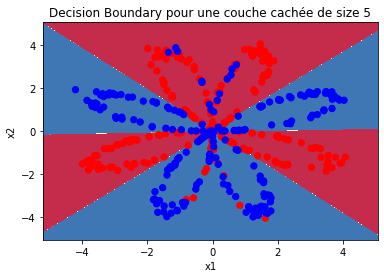

In [101]:
n_h = 5
parameters = nn_model(X, Y, n_h = n_h, num_iterations = 10000, print_cost=True)

# Plot la decision boundary
try:
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
except:
    print("Suite à un problème de version matplotlib, vous ne voyez pas les points initiaux. Reprenez le graphique au début du notebook et imaginez les points comme étant plot.")
    pass
plt.title("Decision Boundary pour une couche cachée de size " + str(n_h))

**Résultat attendu**:

<table style="width:40%">
  <tr>
    <td>Coût après itération 9000</td>
    <td> 0.178517 </td> 
  </tr>
  
</table>


In [102]:
# Print l'accurary
predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100) + '%')

Accuracy: 91%


**Résultat attendu**: 

<table style="width:15%">
  <tr>
    <td>Accuracy</td>
    <td> 91% </td> 
  </tr>
</table>

L'accurary est beaucoup plus élevé que celui de la régression logistique. Le modèle a pu apprendre le pattern des feuilles de la fleur. Contrairement à la régression logistique, les réseaux de neurones profonds sont capables de traiter des problèmes non linéaires.

Essayez maintenant avec plusieurs nombres de neurones différents dans la couche cachée. 

### 4.6 - Tuning du nombre de neurones dans la couche cachée ###

Exécutez le code suivant. Cela devrait prendre 1-2 minutes. Vous observerez des comportements différents du modèle selon le nombre de neurones que vous aurez défini dans la couche cachée.

Accuracy for 1 hidden units: 67.5 %
Accuracy for 2 hidden units: 67.25 %
Accuracy for 3 hidden units: 90.75 %
Accuracy for 4 hidden units: 66.75 %
Accuracy for 5 hidden units: 91.25 %
Accuracy for 20 hidden units: 90.5 %
Accuracy for 50 hidden units: 90.75 %


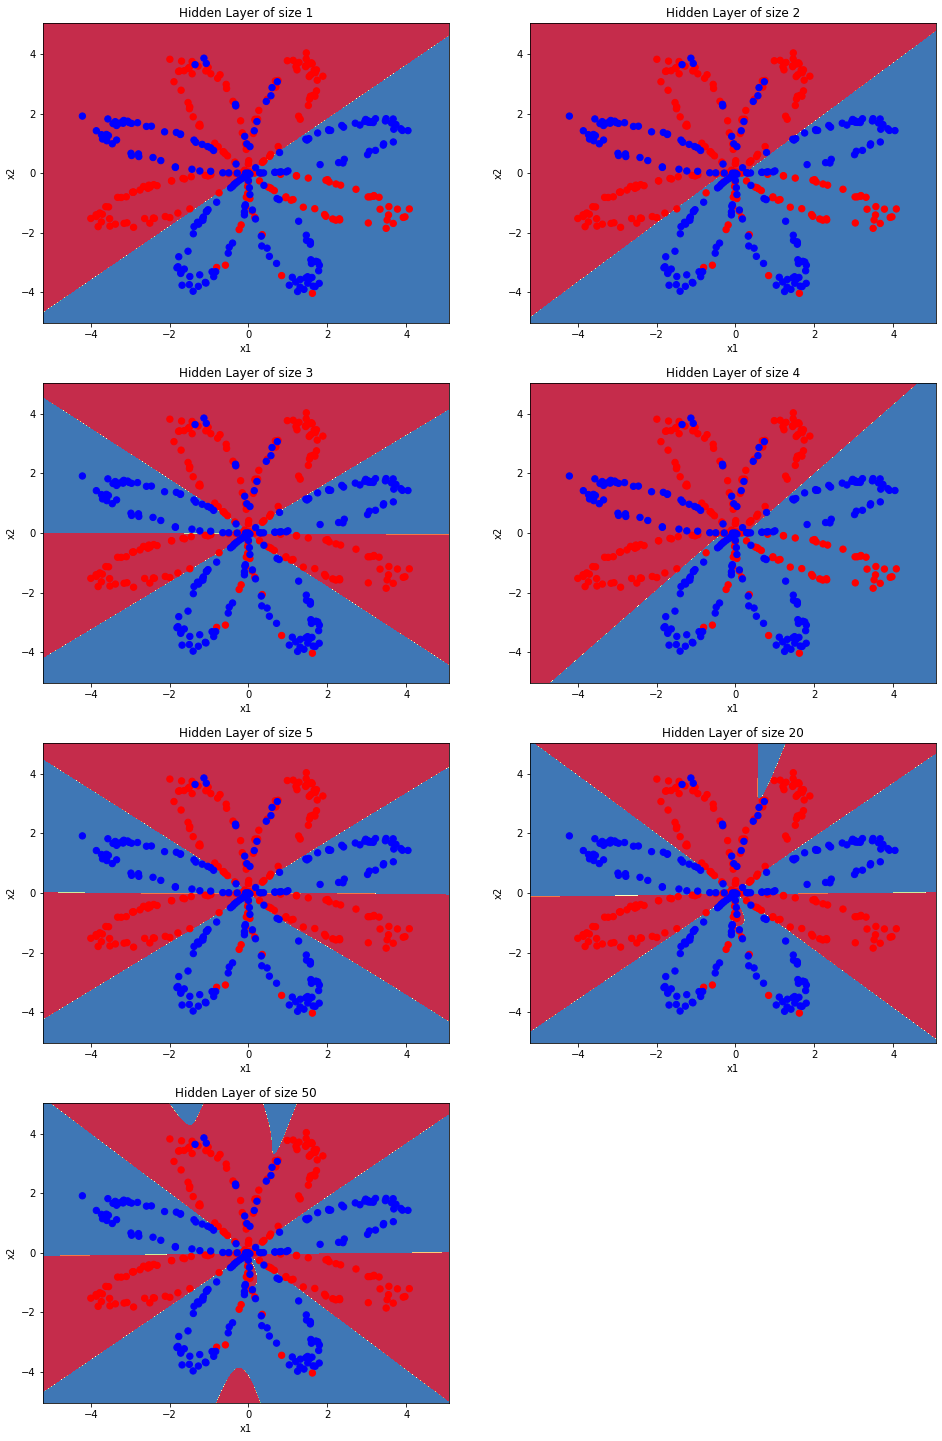

In [103]:
# Cela devrait prendre 2 minutes

plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    try:
        plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    except:
        print("Suite à un problème de version matplotlib, vous ne voyez pas les points initiaux. Reprenez le graphique au début du notebook et imaginez les points comme étant plot.")
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

**Interpretation**:
- Le plus gros modèle est capable de mieux classifier le jeu de données de train, jusqu'à overfitter les données. 
- Le meilleur modèle semble être celui avec 5 neurones.

Une méthode pour éviter l'overfitting est la régularisation. Nous aurons peut etre l'occasion de voir ça dans un futur workshop.

References:
- http://scs.ryerson.ca/~aharley/neural-networks/
- http://cs231n.github.io/neural-networks-case-study/